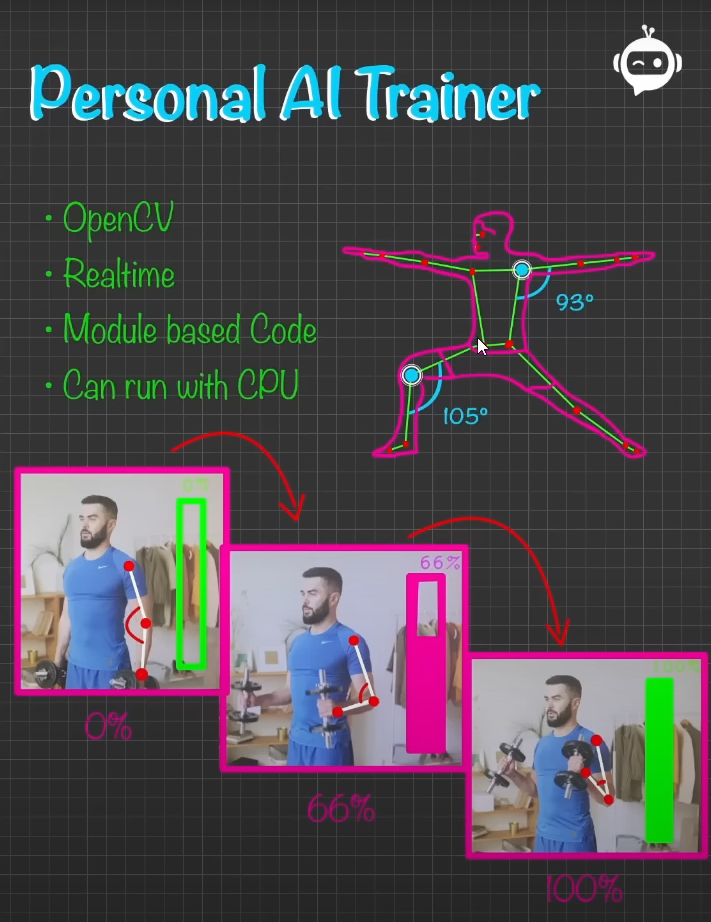

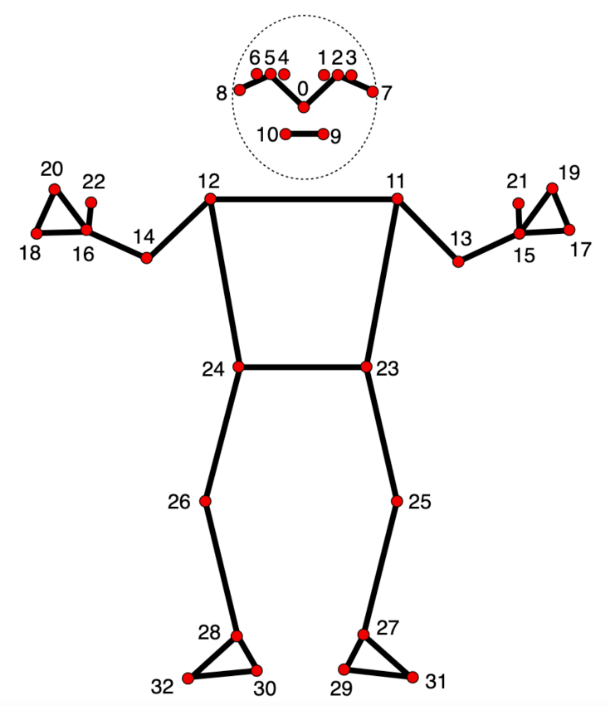

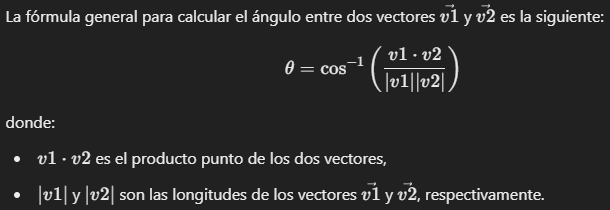

In [9]:
import cv2 
import mediapipe as mp
import numpy as np
import math

In [31]:
cap = cv2.VideoCapture(0)

# Establecer dimensiones deseadas para la cámara (por ejemplo, 1280x720)
width = 1280
height = 720
cap.set(3, width)  # Establece el ancho de la imagen
cap.set(4, height)  # Establece la altura de la imagen

mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils

# Curls
curls = 0 # Numero de curls
curling = False  # Flag para curl completo

# Calcula el angulo entre 3 landmarks
def calculate_angle(p1, p2, p3):
    # Convertimos los puntos en vectores (usando coordenadas x, y)
    v1 = np.array([p1.x - p2.x, p1.y - p2.y])  # Vector p1 -> p2
    v2 = np.array([p3.x - p2.x, p3.y - p2.y])  # Vector p3 -> p2
    
    # Producto punto entre v1 y v2
    dot_product = np.dot(v1, v2)
    
    # Longitudes de los vectores
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    
    # Cálculo del ángulo en radianes
    angle_radians = np.arccos(dot_product / (magnitude_v1 * magnitude_v2))
    
    # Convertimos el ángulo a grados
    angle_degrees = math.degrees(angle_radians)
    
    # Pintamos los landmarks
    paint_landmarks([p1, p2, p3])
    
    return angle_degrees

# Recibe un array de landmarks que va a pintar (BGR)
def paint_landmarks(landmarks, color = (255, 0, 0)):
    for lm in landmarks:
        # Obtener las coordenadas del punto
        h, w, _ = img.shape
        centerX, centerY = int(lm.x * w), int(lm.y * h)

        # Dibuja un círculo de color rojo en el punto
        cv2.circle(img, (centerX, centerY), 10, color, cv2.FILLED) 

# Funcion para comprobar que el curl se haga correctamente
def curl_check(p1, p2, p3, angle, angle_min = 32, angle_max = 150):
    global curls, curling  # Permite modificar la variable global
    
    if(angle < angle_min or angle > angle_max):
        paint_landmarks([p1, p2, p3], color = (0, 255, 0))
    
    if(angle < angle_min and not curling):
        curling = True
    elif angle > angle_max and curling:
        curls += 1
        curling = False
    
    cv2.putText(img, f'Curls: {str(curls)}', (15,75), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 3)

while True:
    succes, img = cap.read()
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = pose.process(imgRGB) 
    
    if result.pose_landmarks:
        lm = result.pose_landmarks.landmark # lm[x] para acceder a cada uno de los puntos
        right_curl_points = [lm[12], lm[14], lm[16]] # Recoge los landmark relevantes para el right curl
        angle = calculate_angle(right_curl_points[0], right_curl_points[1], right_curl_points[2]) # Calcula el angulo
        
        # Checkear ejercicio
        curl_check(right_curl_points[0], right_curl_points[1], right_curl_points[2], angle)
        
        # Mostrar el angulo
        h, w, _ = img.shape
        centerX, centerY = int(right_curl_points[1].x * w), int(right_curl_points[1].y * h)
        cv2.putText(img, str(int(angle)), (centerX + 10,centerY+5), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), 2)

    cv2.imshow("Image", img)
    if cv2.waitKey(1) & 0xFF == 27:  # Presionar 'Esc' para salir
        break
    
cap.release()
cv2.destroyAllWindows()